# Simulating J

Following the study material and meeting on the 19th of February we will need to approximate the J function. Which gives the reward for this step taking into account all future steps. For this we first need to calculate it for different states

In [115]:
import numpy as np
from pyworld3 import World3
from matplotlib import pyplot as plt
import pandas as pd

## Definition of J and proposed reward function

In [116]:
def J_func(reward):
    """ 
    In:
        reward - numpy array: rewards for the simlation
    Out: 
        Array of J function values
    """
    iterations = reward.shape[0]
    J = np.zeros((iterations,1))
    J[iterations-1] = reward[iterations-1]
    for k in range(2,iterations+1):
        # J[n] is the reward at step n plus J[n+1]
        J[iterations-k] = reward[iterations-k] + J[iterations-k+1] 
    return J

def reward_pop(world):
    # reward function, trying simple with population
    return world.pop

### Testing on standard run

In [117]:
world_standard = World3(year_max=2100)
world_standard.set_world3_control()
world_standard.init_world3_constants()
world_standard.init_world3_variables()
world_standard.set_world3_table_functions()
world_standard.set_world3_delay_functions()
world_standard.run_world3(fast=False)

In [118]:
reward = reward_pop(world_standard)
J = J_func(reward)

## Random start
To do this well we need to explore the entire space of possible states of the world3 model. FOr this we will take a randomized start. Exploring the entire state might require too much calculations, a full run takes approximately 1.8 seconds (dependent on computer). only $1000$ full runs will take about half an hour, therefore it might be better to try to only explore more relevant parts of the state space \
Current idea: Draw each state variable that we want to change from a gaussian distribution dependent on how they behave in the standard run. The year can be drawn from a uniform distribution.

In [119]:
def get_mu_sigma(world, variable):
    data = getattr(world, variable)
    mean = np.mean(data) 
    std = np.std(data)
    return mean, std

### Saving values
All values need to be saved and stored some way. There are two parts to this, one storing at runtime. And then storing between runs. \
Between runs it is easiest to store it as a csv file with named columns to easier extract data at a later time. \
Runtime we should use numpy in calculations since it is fast, then create a pandas dataframe that easily can be converted to a csv file. \
Taking this into account when designing the main loop

In [120]:
def generate_initial(total_runs, variables):
    """ 
    In: 
        total_runs - int: total number of simulations to generate initial data for
        variables  - list[String]: the variables that will be initialised randomly using the standard run
    Out:
        initial_variables - list[dictionary<String,float>]: Dictionary with the initial variables 
    """
    array = []
    for _ in range(total_runs):
        dict = {}
        for variable in variables:
            mu, sigma = get_mu_sigma(world_standard, variable)
            value = np.random.normal(mu, sigma)
            while value < 0:
                value = np.random.normal(mu, sigma)
            dict[variable+"i"]=value 
            

        array.append(dict)
    return array

def main_loop(reward_func):
    """ 
    In: 
        reward_func function: function that takes a world3 object as indata and returns an array of rewards
    """
    runs = 10
    variables = ["p1","p2","p3","p4","nr"]
    initial_values = generate_initial(runs, variables)
    # behöver en numpy array att lagra alla J i, hur stor? storlek på varje run x state variables + tid
    n = 401
    variables.append("time")
    df = pd.DataFrame(np.nan, index=range(n*runs), columns=variables)
    df["J"] = np.nan
    for run in range(runs):
        # running the model
        world3 = World3(year_max=2100)
        world3.set_world3_control()
        world3.init_world3_constants(**initial_values[run])
        world3.init_world3_variables()
        world3.set_world3_table_functions()
        world3.set_world3_delay_functions()
        world3.run_world3(fast=False)

        # reward and J
        reward = reward_func(world3)
        J = J_func(reward)
        df.loc[n*run:n*(run+1)-1, "J"] = J

        # writing to dataframe
        for variable in variables:
            column = getattr(world3, variable)
            df.loc[n*run:n*(run+1)-1, variable] = column
        print("loop ", run+1, " complete")
    return df

In [121]:
#main_loop()
def g(world):
    # reward function, trying simple with population
    return world.le

dataframe = main_loop(g)

# sparar till csv fil
dataframe.to_csv("DataTest.csv", index=False)

loop  1  complete
loop  2  complete
loop  3  complete
loop  4  complete
loop  5  complete
loop  6  complete
loop  7  complete
loop  8  complete
loop  9  complete
loop  10  complete


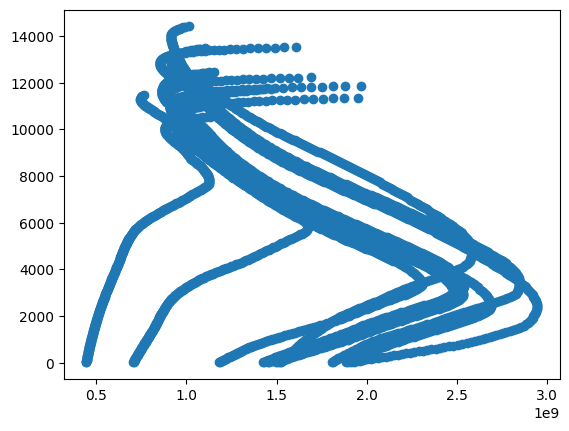

In [126]:
plt.scatter(dataframe["p1"], dataframe["J"])
plt.show()